# Interested in what the spectra look like for things we weren't expecting to be interesting initially: di-amino-quinazoline and ponatinib and carbonic anhydrase II (with bosutinib)

In [1]:
from assaytools import platereader
from glob import glob

import matplotlib.pyplot as plt

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from lxml import etree
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns

sns.set(style='white')
sns.set_context('talk')

In [3]:
#This function allows us to import a section from an xml formated data file and convert itto a pandas dataframe
def xml2df_section(file,section):

    root = etree.parse(file)

    data = []

    reads = root.xpath("/*/Section[%s]/*/Well"%section)
    Sections = root.xpath("/*/Section")
    print Sections[(section-1)].attrib['Name'] 
    section_name = Sections[(section-1)].attrib['Name'] 
    
    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(s.text, float(s.attrib['WL']), r.attrib['Pos'])
        for r in reads
        for s in r]
    
    dataframe = pd.DataFrame(data, columns=['fluorescence','wavelength (nm)','Well'])
            
    ### dataframe_rep replaces 'OVER' (when fluorescence signal maxes out) with '3289277', an arbitrarily high number

    dataframe_rep = dataframe.replace({'OVER':'3289277'})

    dataframe_rep[['fluorescence']] = dataframe_rep[['fluorescence']].astype('float')
            
    dataframe_pivot = pd.pivot_table(dataframe_rep, index = 'wavelength (nm)', columns = ['Well'])
    
    #Rearrange columns so they're in the right order
    cols =  dataframe_pivot['fluorescence'].columns.tolist()
    cols = [cols[0]] + cols[4:12] + cols[1:4] + [cols[12]] + cols[16:23] + cols[13:16]
    dataframe_reindex =  dataframe_pivot.reindex_axis(cols,level='Well',axis=1)
    
    return [dataframe_reindex,section_name]

In [4]:
#This function allows us to plot spectra choosing ylim and 
def plot_spectra_grid_advanced(file_set,protein,ligands,ligand,section,ylim,lines):
    grid = len(protein) + len(ligand)

    file = file_set[protein]
    
    # make a dataframe
    [df,section_name] = xml2df_section(file,section)
    
    # pick a title
    title = "%s - %s: %s" %(protein, ligand, section_name)

    # define ylim and lines
    
    ylim = ylim
    lines = lines
    
    # plot the spectra
    fig = plt.figure(figsize=(8,6));
    ax = df['fluorescence'].iloc[:,12].plot(ylim=(0,ylim),legend=False, linewidth=4,color='m',title=title);
    for line in lines:
        ax.axvline(x=line,color='0.7',linestyle='--');
    for i in range(11):
        df['fluorescence'].iloc[:,i].plot(linewidth=3,c=cm.hsv(i*15), ax = ax);
        df['fluorescence'].iloc[:,11+i].plot(legend=False, linewidth=4,c=cm.gray(i*15+50), ax = ax, fontsize =20);
    sns.despine()
    plt.xlim(250,600)
    plt.xlabel('wavelength (nm)', fontsize=20)
    plt.text(550,0.9*ylim,"lines=%s"%lines,color='0.7')
    plt.tight_layout();

### Let's start with Ponatinib

In [5]:
file_set = {'p38': "/Users/hansons/Documents/github/fluorescence-assay-manuscript/data/spectra/p38/2016-03-30/p38_Pon_20160330_160326.xml"}
ligands = ['Pon']

In [6]:
ylim = 300000
lines = [325,480]

em280


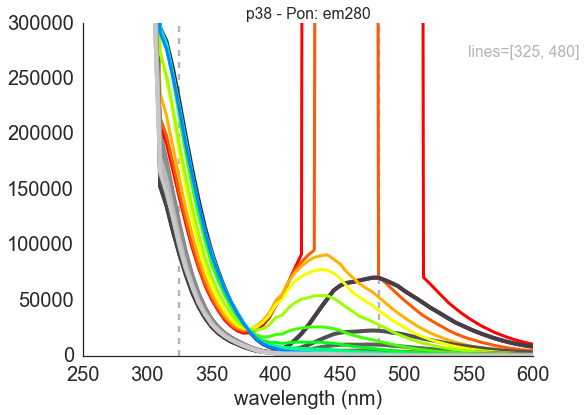

In [7]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'Pon',1,ylim,lines)

Hmmm. Interesting seems like the protein peak has shifted so it is now cut off, though it does seem to exhibit the same FRET behavior.

In [8]:
ylim = 100000
lines = [325,480]

em280


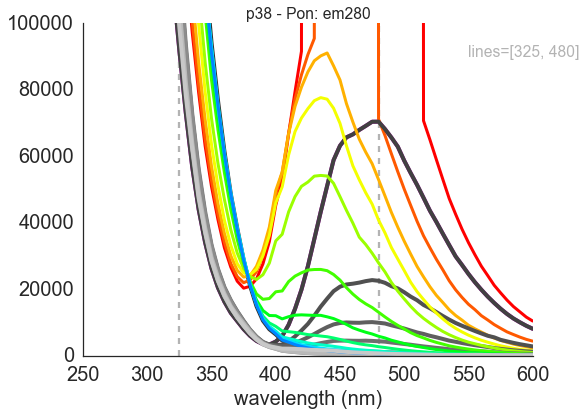

In [9]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'Pon',1,ylim,lines)

Whoa, cool there's actuall a leftward shift upon protein binding.

In [10]:
ylim = 300000

em340


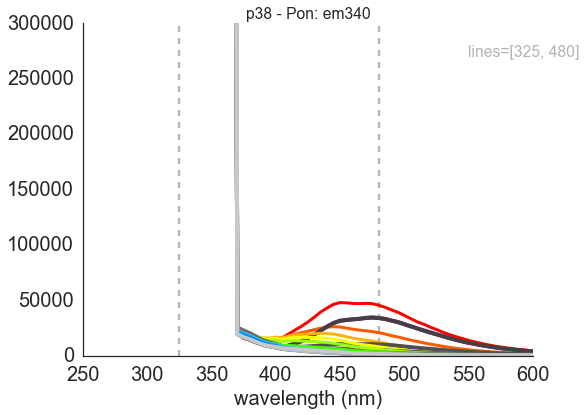

In [11]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'Pon',2,ylim,lines)

In [12]:
ylim = 50000

em340


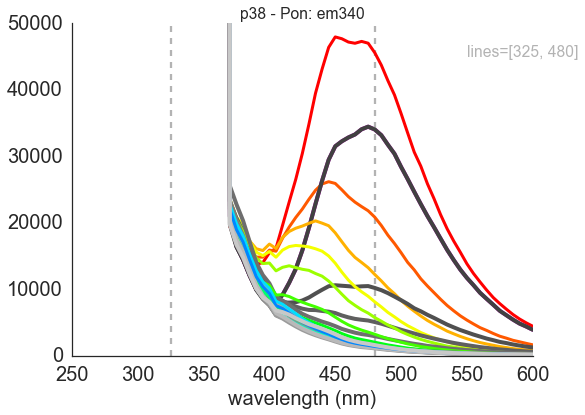

In [13]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'Pon',2,ylim,lines)

Similar peak shift here?

abs


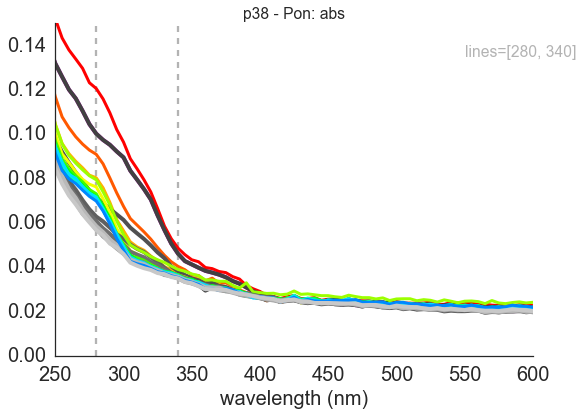

In [14]:
ylim = 0.15
lines = [280,340]
plot_spectra_grid_advanced(file_set,'p38',ligands,'Pon',5,ylim,lines)

## Now let's let at DQA

In [15]:
file_set = {'p38': "/Users/hansons/Documents/github/fluorescence-assay-manuscript/data/spectra/p38/2016-03-30/p38_DQA_20160330_171906.xml"}
ligands = ['DQA']

In [16]:
ylim = 320000
lines = [325,480]

em280


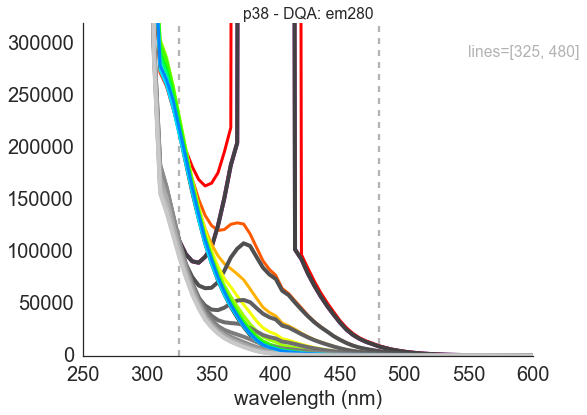

In [17]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'DQA',1,ylim,lines)

No real FRET signal here, though there is a difference in the signal when the protein is there. Maybe this means there's a tiny amount of FRET?

em340


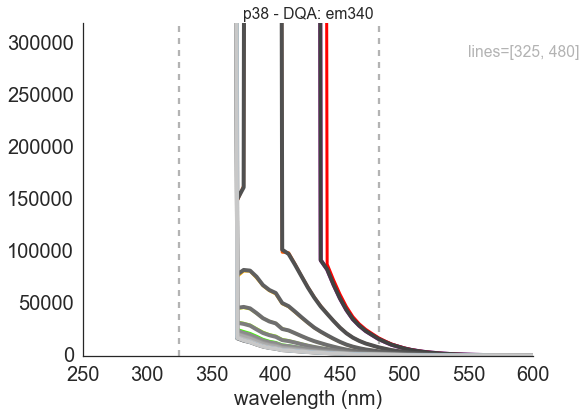

In [18]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'DQA',2,ylim,lines)

Interesting. There is basically no difference between complex and ligand fluorescence.

In [19]:
ylim = 0.3
lines = [280,325]

abs


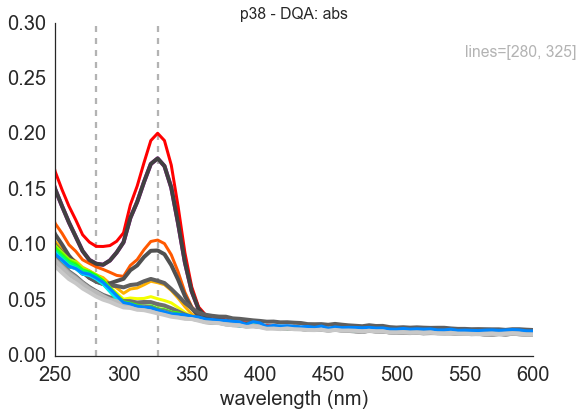

In [20]:
plot_spectra_grid_advanced(file_set,'p38',ligands,'DQA',5,ylim,lines)

## Okay, now what about CAII

In [21]:
file_set = {'CAII': "/Users/hansons/Documents/github/fluorescence-assay-manuscript/data/spectra/CAII/2016-03-15/CAII_Bos_20160315_144336.xml"}
ligands = ['Bos']

em280


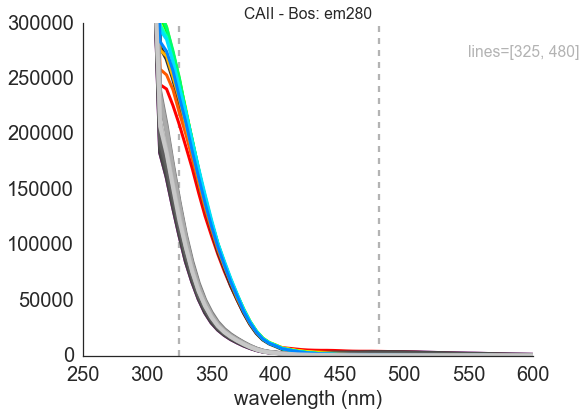

In [22]:
ylim = 300000
lines = [325,480]
plot_spectra_grid_advanced(file_set,'CAII',ligands,'Bos',1,ylim,lines)

em280


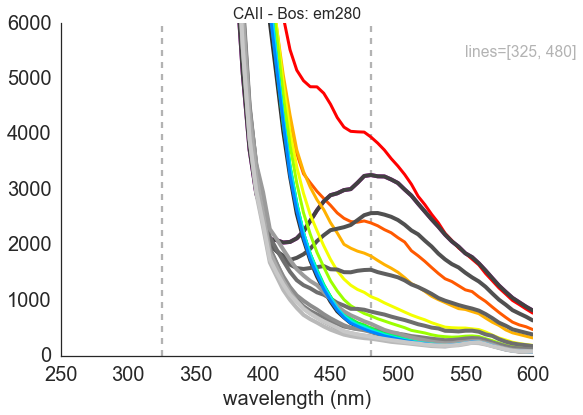

In [23]:
ylim = 6000
lines = [325,480]
plot_spectra_grid_advanced(file_set,'CAII',ligands,'Bos',1,ylim,lines)

Hmmm, so you do see kind of a FRET effect here.

abs


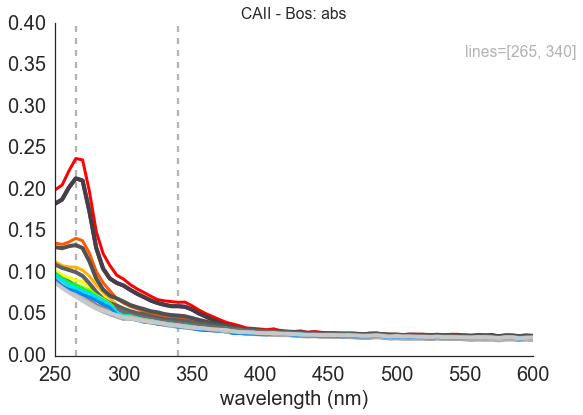

In [24]:
ylim = 0.4
lines = [265,340]
plot_spectra_grid_advanced(file_set,'CAII',ligands,'Bos',5,ylim,lines)

Hmmm seems like the ligand itself absorbs at 280 nm.

Also, I wonder if this general lifting of the spectrum between the peak and 280 is a characteristic of non-specific binding (since we see it for both DQA binding to p38 and bosutinib binding to CAII), rather than an actual shifting of the max of the peak which would correspond to specific binding?